In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [18]:
df = pd.read_csv("psl_cfx_2010_2016_complet.csv")

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")

# Série mensuelle explicite
y = df["passages_urgences"].asfreq("ME").ffill()

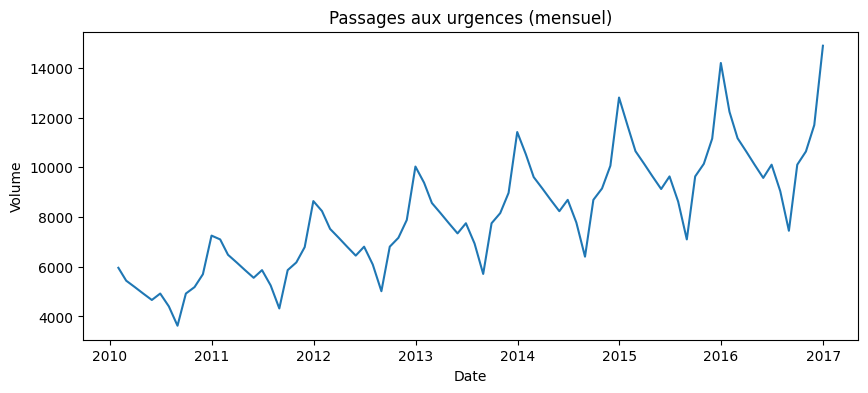

In [19]:
plt.figure(figsize=(10,4))
plt.plot(y)
plt.title("Passages aux urgences (mensuel)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

In [20]:
result = adfuller(y)
print("ADF p-value :", result[1])

ADF p-value : 0.6719325169497933


In [21]:
horizon = 12
train_y = y.iloc[:-horizon]
test_y  = y.iloc[-horizon:]


In [22]:
model = SARIMAX(
    train_y,
    order=(0,0,2),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result = model.fit()
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                    passages_urgences   No. Observations:                   72
Model:             SARIMAX(0, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -117.540
Date:                              Mon, 02 Feb 2026   AIC                            245.081
Time:                                      12:45:34   BIC                            254.114
Sample:                                  01-31-2010   HQIC                           248.448
                                       - 12-31-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.9655      3.273      0.600      0.548      -4.450       8.381
ma.L2          0.84

c:\Users\HugoG\OneDrive\Documents\GitHub\Smartcare_analytics\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
forecast = result.get_forecast(steps=horizon)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

In [26]:
mae = mean_absolute_error(test_y, pred)
rmse = np.sqrt(mean_squared_error(test_y, pred))

print("MAE :", mae)
print("RMSE :", rmse)
print("AIC :", result.aic)

MAE : 490.95165249293694
RMSE : 497.64614958862745
AIC : 245.08060460170216


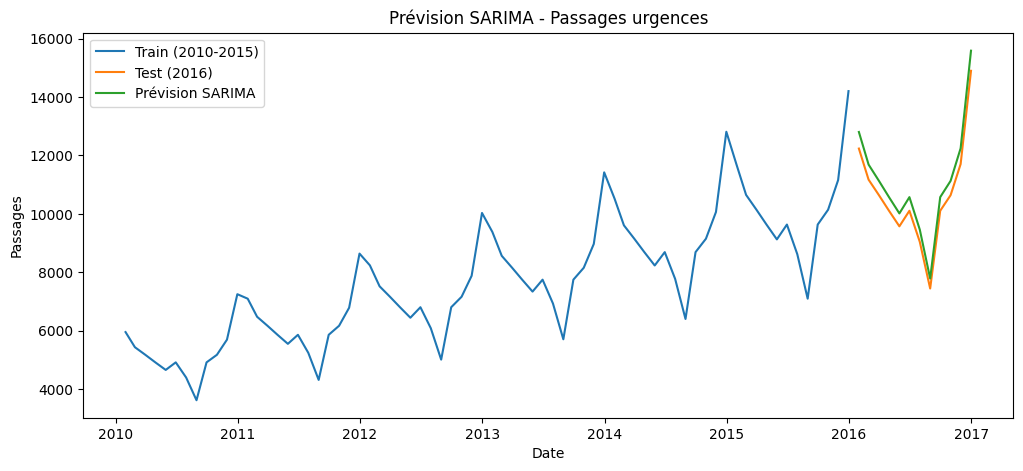

In [27]:
plt.figure(figsize=(12,5))
plt.plot(train_y, label="Train (2010-2015)")
plt.plot(test_y, label="Test (2016)")
plt.plot(pred, label="Prévision SARIMA")

plt.fill_between(
    pred.index.to_pydatetime(),
    conf_int.iloc[:,0].values,
    conf_int.iloc[:,1].values,
    alpha=0.3
)

plt.title("Prévision SARIMA - Passages urgences")
plt.xlabel("Date")
plt.ylabel("Passages")
plt.legend()
plt.show()

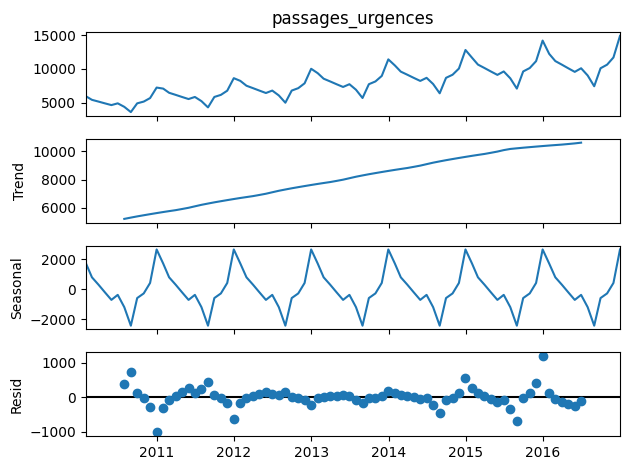

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(y, model="additive", period=12)
decomp.plot()
plt.show()
